In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np
import glob
from matplotlib import pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
directory_path = "F:/Images/augmented/aug_images"
train_num = 0
train_images = []

SIZE_Y = 256
SIZE_X = 256

In [5]:
for img_path in glob.glob(os.path.join(directory_path, "*.png")):
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  train_images.append(img)

# Convert the lists to array for machine learning processing using np.array()
train_images = np.array(train_images)

In [6]:
len(train_images)

1000

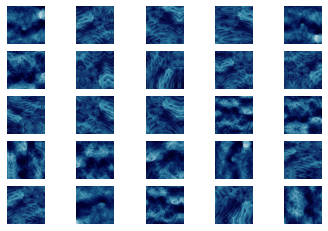

In [7]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(train_images[i])
plt.show()

In [8]:
# Convert to float and scale.
train_images = train_images.astype('float32')
# scale from [0,255] to [-1,1]
train_images = (train_images - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                          #original images to -1 to 1 to match the output of generator.

In [9]:
# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(256,256,3)):
  model = keras.models.Sequential()

  model.add(keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #128x128x128
  model.add(keras.layers.LeakyReLU(alpha=0.2))

  model.add(keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')) #64x64x128
  model.add(keras.layers.LeakyReLU(alpha=0.2))

  model.add(keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')) #32x32x64
  model.add(keras.layers.LeakyReLU(alpha=0.2))

  model.add(keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')) #16x16x64
  model.add(keras.layers.LeakyReLU(alpha=0.2))

  model.add(keras.layers.Flatten()) #shape of 16384
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Dense(1, activation='sigmoid')) #shape of 1
  # compile model
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        3

d:\Programming\miniconda3\envs\keras\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100 

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.       

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
  model = keras.models.Sequential()
  # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
  n_nodes = 128 * 16 * 16  #8192 nodes
  model.add(keras.layers.Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Reshape((16, 16, 128)))  #16x16x128 dataset from the latent vector. 
  # upsample to 32x32
  model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  # upsample to 64x64
  model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #64x64x128
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  # upsample to 128x128
  model.add(keras.layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')) #128x128x64
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  # upsample to 256x256
  model.add(keras.layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')) #256x256x64
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  # generate
  model.add(keras.layers.Conv2D(3, (8,8), activation='tanh', padding='same')) #256x256x3
  return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      262272    
 ranspose)                                            

In [11]:
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
  discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
  # connect generator and discriminator
  model = keras.models.Sequential()
  model.add(generator)
  model.add(discriminator)
  # compile model
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [12]:
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
  # choose random images
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # select the random images and assign it to X
  X = dataset[ix]
  # generate class labels and assign to y
  y = np.ones((n_samples, 1)) ##Label=1 indicating they are real
  return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict using generator to generate fake samples. 
  X = generator.predict(x_input)
  # Class labels will be 0 as these samples are fake. 
  y = np.zeros((n_samples, 1))  #Label=0 indicating they are fake
  return X, y

In [46]:
# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=32):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                                  #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
      # Train the discriminator on real and fake images, separately (half batch each)
      #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
      # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
      #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
      # The generator wants the discriminator to label the generated samples
      # as valid (ones)
      #This is where the generator is trying to trick discriminator into believing
      #the generated image is true (hence value of 1 for y)			
			y_gan = np.ones((n_batch, 1))
            
      # Generator is part of combined model where it got directly linked with the discriminator
      # Train the generator with latent_dim as x and 1 as y. 
      # Again, 1 as the output as it is adversarial and if generator did a great
      #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
      # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save("F:/Images/generator_black_200epo.h5")

In [47]:
#Train the GAN

# size of the latent space
latent_dim = 128
# create the discriminator
discriminator = define_discriminator()
# create the generator
#generator = define_generator(latent_dim)
generator = keras.models.load_model("F:/Images/generator_black_100epo.h5", compile=False)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = train_images
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100, n_batch=16)

1/1 [==============================] - 0s 153ms/step
Epoch>1, Batch 1/62, d1=0.688, d2=0.767 g=0.656
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 2/62, d1=0.659, d2=0.746 g=0.667
1/1 [==============================] - 0s 26ms/step
Epoch>1, Batch 3/62, d1=0.660, d2=0.739 g=0.670
1/1 [==============================] - 0s 24ms/step
Epoch>1, Batch 4/62, d1=0.671, d2=0.730 g=0.679
1/1 [==============================] - 0s 25ms/step
Epoch>1, Batch 5/62, d1=0.670, d2=0.712 g=0.683
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 6/62, d1=0.681, d2=0.722 g=0.686
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 7/62, d1=0.691, d2=0.702 g=0.689
1/1 [==============================] - 0s 26ms/step
Epoch>1, Batch 8/62, d1=0.691, d2=0.708 g=0.699
1/1 [==============================] - 0s 26ms/step
Epoch>1, Batch 9/62, d1=0.698, d2=0.702 g=0.697
1/1 [==============================] - 0s 25ms/step
Epoch>1, Batch 10/62, d1=0.698, d2=0.709 g=0.69

1/1 [==============================] - 0s 149ms/step


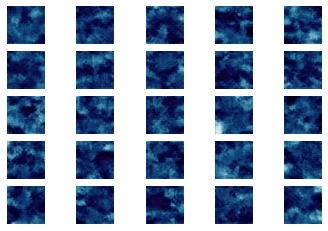

In [17]:
# Now, let us load the generator model and generate images

# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = keras.models.load_model("F:/Images/generator_black_100epo.h5") #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(128, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

1/1 [==============================] - 0s 168ms/step


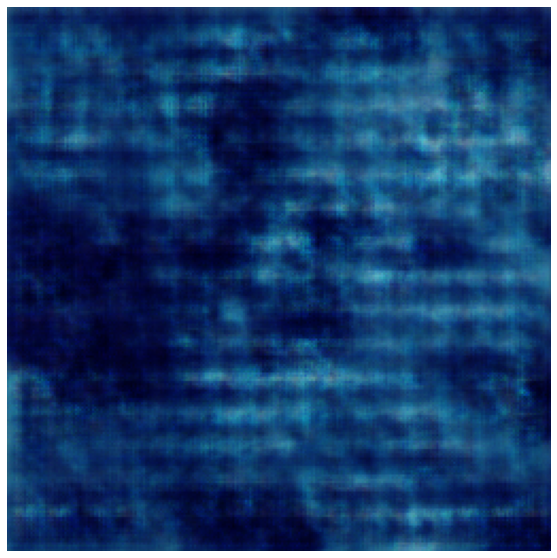

In [52]:
# load model
model = keras.models.load_model("F:/Images/generator_black_200epo.h5") #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(128, 1)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# plot the result
fig, ax = plt.subplots(1, figsize=(10,10))
ax.axis("off")
ax.imshow(X[0, :, :, :], cmap="gray") # cmap="gray" only works on a grayscaled image